# FUM Computer Vision - Session 04

Visit the [course repository on Github](https://github.com/alifarrokh/FUM-ComputerVision) to get access to other sessions.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from math import floor, ceil, sqrt
import pywt
import skimage

import warnings
warnings.filterwarnings("ignore")

### Utils

In [ ]:
def imshow(*args, figsize=10, title=None, fontsize=12):
    if isinstance(figsize, int):
        figsize = (figsize, figsize)
    images = args[0] if type(args[0]) is list else list(args)
    if title is not None:
        assert len(title) == len(images), "Please provide a title for each image."
    plt.figure(figsize=figsize)
    for i in range(1, len(images)+1):
        plt.subplot(1, len(images), i)
        if title is not None:
            plt.title(title[i-1], fontsize=fontsize)
        plt.imshow(images[i-1], cmap='gray')
        plt.axis('off')
    plt.show()

In [ ]:
def normalize(a):
    if isinstance(a, list):
        return list(map(normalize, a))
    if isinstance(a, tuple):
        return tuple(normalize(list(a)))
    return ((a - a.min()) / (a.max() - a.min())) * 255

# Haar Wavelet Transform 

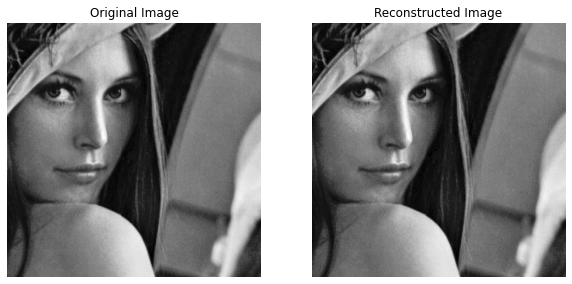

In [ ]:
img = cv2.imread('lena.tif', cv2.IMREAD_GRAYSCALE)

# wavelet transform
cA, (cH, cV, cD) = pywt.dwt2(img, 'haar', mode='periodization')

# inverse wavelet transform
coefficients = [cA, (cH, cV, cD)]
img_i = pywt.idwt2(coefficients, 'haar', mode='periodization')
img_i = img_i.astype('uint8')

imshow(img, img_i, figsize=(10), title=['Original Image', 'Reconstructed Image'])

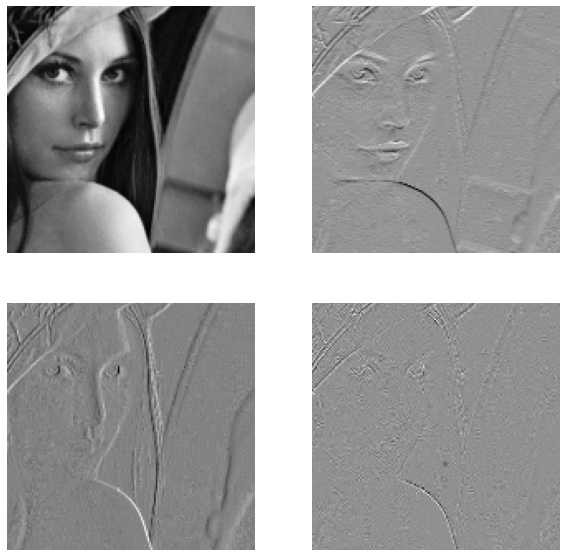

In [ ]:
img = cv2.imread('lena.tif', cv2.IMREAD_GRAYSCALE)

# wavelet transform
cA, (cH, cV, cD) = pywt.dwt2(img, 'haar', mode='periodization')

# Plot the results
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(cA, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cH, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(cV, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cD, cmap='gray')
plt.axis('off')
plt.show()

### Multi-level Wavelet Decomposition

We can use `pywt.wavedec2()` to perform multi-level wavelet decomposition.

```
C = pywt.wavedec2(img, 'filter_name', mode='mode', level=n)
```
Where $C$ is the list of coefficients:
$$
C = [cA_n, (cH_n, cV_n, cD_n), (cH_{n-1}, cV_{n-1}, cD_{n-1}), ..., (cH_1, cV_1, cD_1)]
$$
And we can access the $n$th level coefficients in this way:
```
c_level1 = C[-1]
c_level2 = C[-2]
...
c_leveln = C[-n]
cAn = C[0]
```

**Note:** the default value for `level` is the maximum possible level in decomposition:
$$
⌊log_2(\frac{img\_len}{filter\_len - 1})⌋
$$

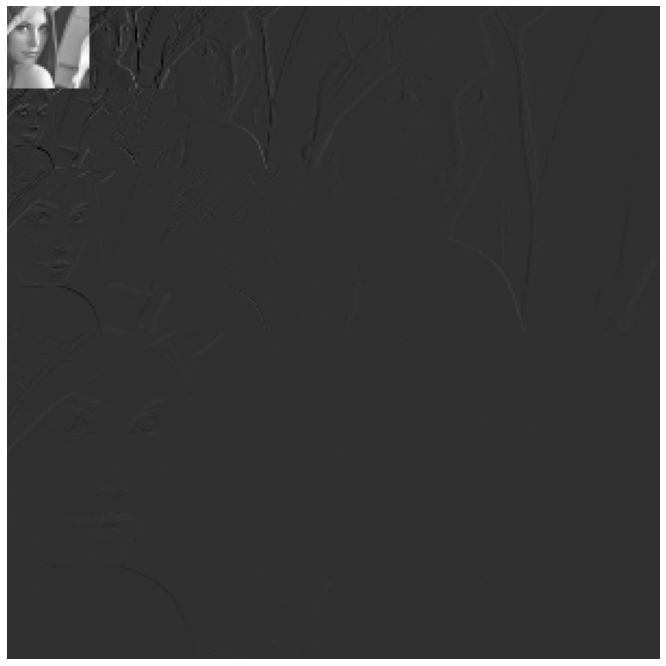

In [ ]:
img = cv2.imread('lena.tif', cv2.IMREAD_GRAYSCALE)

# wavelet transform
coeffs = pywt.wavedec2(img, 'haar', mode='periodization', level=3)

# Put coefficients in a matrix
c_matrix, c_slices = pywt.coeffs_to_array(coeffs)

# Plot
plt.figure(figsize=(12, 12))
plt.imshow(c_matrix, cmap='gray')
plt.axis('off')
plt.show()

### A note on `pywt.coeffs_to_array()`


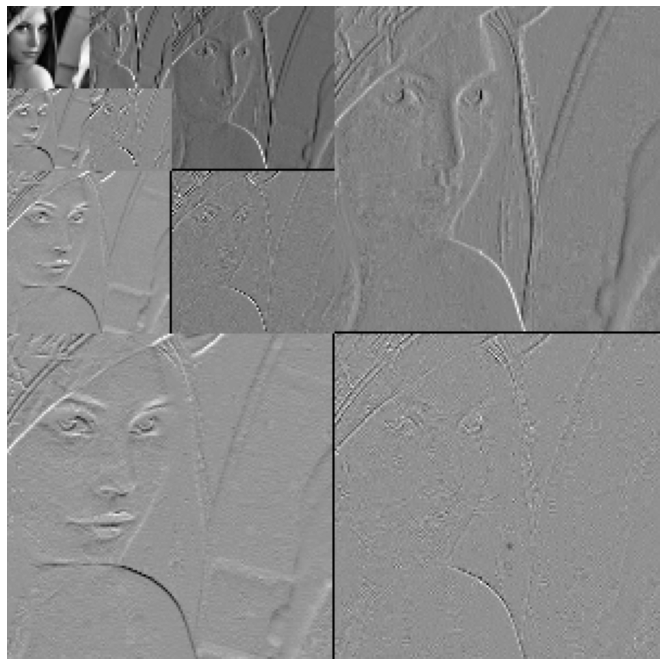

In [ ]:
img = cv2.imread('lena.tif', cv2.IMREAD_GRAYSCALE)

# wavelet transform
coeffs = pywt.wavedec2(img, 'haar', mode='periodization', level=3)
coeffs = normalize(coeffs)

# Put coefficients in a matrix
c_matrix, c_slices = pywt.coeffs_to_array(coeffs)

# Plot
plt.figure(figsize=(12, 12))
plt.imshow(c_matrix, cmap='gray')
plt.axis('off')
plt.show()

### Image Compression

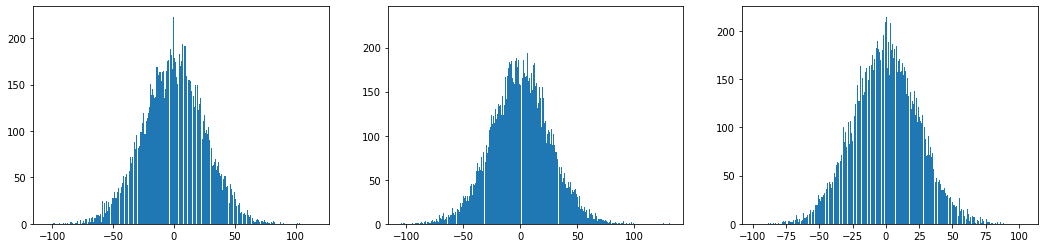

In [ ]:
# wavelet transform
cA, (cH, cV, cD) = pywt.dwt2(img, 'haar', mode='periodization')

# Plot the histogram of the detail coefficients
plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
plt.hist(cH.flatten(), bins=500)

plt.subplot(1, 3, 2)
plt.hist(cV.flatten(), bins=500)

plt.subplot(1, 3, 3)
plt.hist(cD.flatten(), bins=500)

plt.show()

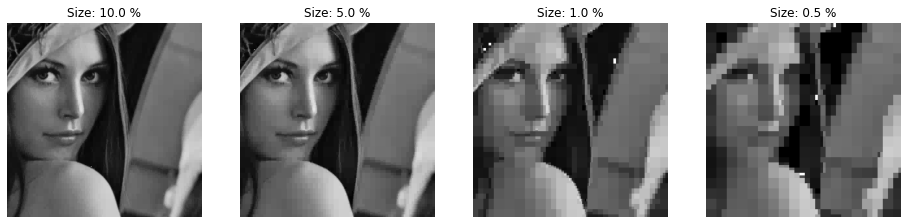

In [ ]:
img = cv2.imread('lena.tif', cv2.IMREAD_GRAYSCALE)

coeffs = pywt.wavedec2(img, 'haar', mode='periodization', level=4)
coeffs_arr, coeff_slices = pywt.coeffs_to_array(coeffs)

coeffs_sorted = np.sort(np.abs(coeffs_arr.reshape(-1)))

images = []
titles = []

for keep in (0.1, .05, 0.01, 0.005):
    thresh = coeffs_sorted[int(np.floor((1-keep)*len(coeffs_sorted)))]
    ind = np.abs(coeffs_arr) > thresh
    coefss_arr_thresh = coeffs_arr * ind

    coefss_thresh = pywt.array_to_coeffs(coefss_arr_thresh, coeff_slices, output_format='wavedec2')
    reconstructed = pywt.waverec2(coefss_thresh, 'haar').astype('uint8')

    images.append(reconstructed)
    titles.append(f'Size: {keep * 100} %')

imshow(images, title=titles, figsize=16)

### A Note on JPEG2000

JPEG2000 is a lossy image compression algorithm that uses wavelet transform as its core. The algorithm was developed after the development of JPEG and offers a better image quality in contrast to JPEG.

Source: [JPEG vs. JPEG2000](https://www.slideshare.net/Rishab2612/comparison-between-jpegdct-and-jpeg-2000dwt-compression-standards)

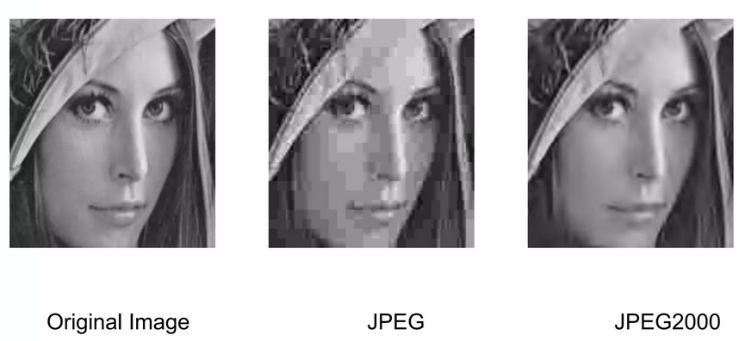

# Image Pyramids

In [ ]:
def gaussian_pyramid(img, num_levels):
    lower = img.copy()
    gaussian_pyr = [lower]
    for i in range(num_levels):
        lower = cv2.pyrDown(lower)
        gaussian_pyr.append(np.float32(lower))
    return gaussian_pyr

In [ ]:
def laplacian_pyramid(gaussian_pyr):
    laplacian_top = gaussian_pyr[-1]
    num_levels = len(gaussian_pyr) - 1
    
    laplacian_pyr = [laplacian_top]
    for i in range(num_levels,0,-1):
        size = (gaussian_pyr[i - 1].shape[1], gaussian_pyr[i - 1].shape[0])
        gaussian_expanded = cv2.pyrUp(gaussian_pyr[i], dstsize=size)
        laplacian = np.subtract(gaussian_pyr[i-1], gaussian_expanded)
        laplacian_pyr.append(laplacian)
    return laplacian_pyr

### Gaussian Pyramids

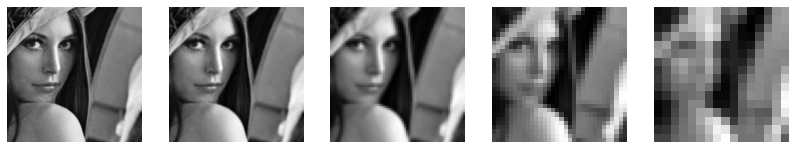

In [ ]:
img = cv2.imread('lena.tif', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (256, 256)) 

g_pyramid = gaussian_pyramid(img, 4)
imshow(g_pyramid, figsize=14)

### Laplacian Pyramids

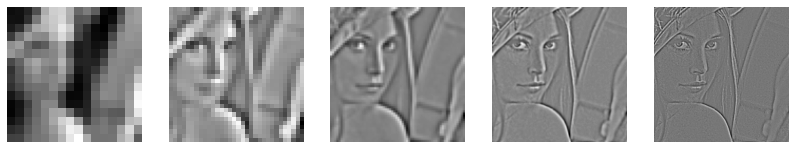

In [ ]:
l_pyramid = laplacian_pyramid(g_pyramid)
imshow(l_pyramid, figsize=14)

### Image Blending

Examples are taken from this [article](https://theailearner.com/tag/image-blending-using-pyramids-opencv/).

In [ ]:
def blend(laplacian_A,laplacian_B,mask_pyr):
    LS = []
    for la, lb, mask in zip(laplacian_A, laplacian_B, mask_pyr):
        ls = lb * mask + la * (1.0 - mask)
        LS.append(ls)
    return LS

In [ ]:
def reconstruct(laplacian_pyr):
    laplacian_top = laplacian_pyr[0]
    laplacian_lst = [laplacian_top]
    num_levels = len(laplacian_pyr) - 1
    for i in range(num_levels):
        size = (laplacian_pyr[i + 1].shape[1], laplacian_pyr[i + 1].shape[0])
        laplacian_expanded = cv2.pyrUp(laplacian_top, dstsize=size)
        laplacian_top = cv2.add(laplacian_pyr[i+1], laplacian_expanded)
        laplacian_lst.append(laplacian_top)
    return laplacian_lst

In [ ]:
!wget -q "https://i0.wp.com/theailearner.com/wp-content/uploads/2019/08/cloud1.jpg"  -O cloud1.jpg
!wget -q "https://i1.wp.com/theailearner.com/wp-content/uploads/2019/08/jet.jpg"  -O jet.jpg

In [ ]:
img1 = cv2.imread('cloud1.jpg')
img1 = cv2.resize(img1, (1800, 1000))
img2 = cv2.imread('jet.jpg')
img2 = cv2.resize(img2, (1800, 1000))

In [ ]:
mask = np.zeros((1000,1800,3), dtype='float32')
mask[250:500,640:1440,:] = (1,1,1)

In [ ]:
num_levels = 7

# Image 1
gaussian_pyr_1 = gaussian_pyramid(img1, num_levels)
laplacian_pyr_1 = laplacian_pyramid(gaussian_pyr_1)

# Image 2
gaussian_pyr_2 = gaussian_pyramid(img2, num_levels)
laplacian_pyr_2 = laplacian_pyramid(gaussian_pyr_2)

# Mask
mask_pyr_final = gaussian_pyramid(mask, num_levels)
mask_pyr_final.reverse()

# Blend the images
add_laplace = blend(laplacian_pyr_1, laplacian_pyr_2, mask_pyr_final)

# Reconstruct the image
final  = reconstruct(add_laplace)[num_levels]
final = normalize(final).astype('uint8')

In [ ]:
# Blend the images using masking
manual = (img1 * (1 - mask)) + (img2 * mask)
manual = normalize(manual).astype('uint8')

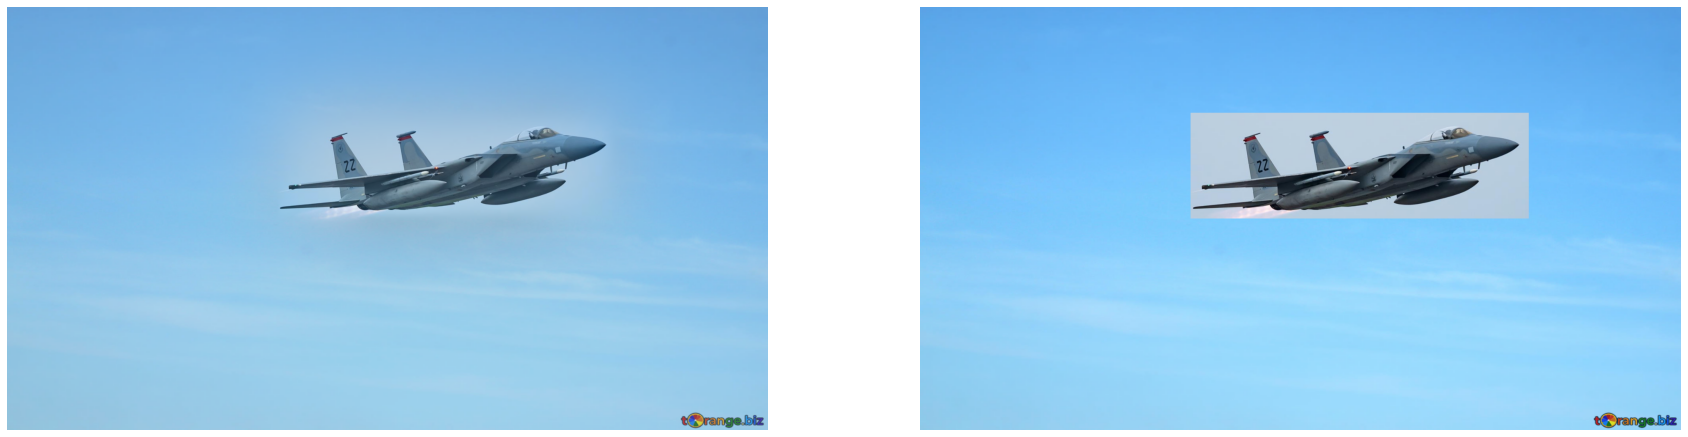

In [ ]:
final_img = cv2.cvtColor(final, cv2.COLOR_BGR2RGB)
manual_img = cv2.cvtColor(manual, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
plt.imshow(final_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(manual_img)
plt.axis('off')
plt.show()